In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use("ggplot")
import pickle
import numpy as np
import sys
sys.path += sys.path + ['../../Scripts/6_Identifications/']
import getInfoFileIdentification as getInfoPeptides
import gettingInfoFromDB as getInfoProteins
import getBiotypes as getBiotype
import getOriginPeptides as getOrigin


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
no display found. Using non-interactive Agg backend


# Get Info from Identifications

Get the information of all the peptides identified in the sample by MS

Running getListFromIdentifiedPeptidesFile  Ribo-db
Minimun Score  11.0
Maximun Score  46.42
Total peptides  2105
Peptides by lenght  {8: 213, 9: 1275, 10: 454, 11: 163}


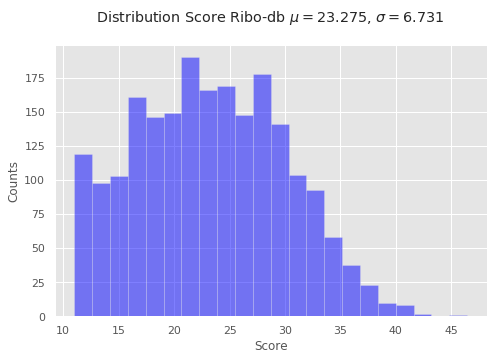

getInfoFileIndentification OK


In [3]:
total_Imm_Ribo = '.../MAPDP_identifications_2020-02-26_14_31_30_IRIC_codes_DOHH2.csv'
getInfoDB_Ribo = getInfoPeptides.getInfoFileIdentification(total_Imm_Ribo, 'Ribo-db')


## Get Info Cannonical

Get the possible canonical protein source of each peptide.

This will give all the proteins that might be at the source of the peptide but ordered by the score-TIS, kozak motif and TPM.

In [4]:
dbInfoCanonical = '.../Proteins/Canonical/DB/1_proteinsUniques.info'
canonicalInfo = getInfoProteins.getFromWherePeptidesDerived(dbInfoCanonical)


getFromWherePeptidesDerived OK


In [5]:
canonicalInfo.getInfoPeptides(getInfoDB_Ribo.scans)

Total Peptides evaluated  2105
Total runtime getInfoPeptides minutes  0.695741216342


## Get info NonCanonical

Get the possible non canonical protein source of each peptide.

This will give all the proteins that might be at the source of the peptide but ordered by the score-TIS, kozak motif and TPM.

In [6]:
dbInfoNonCanonical = '.../Proteins/Non_canonical/DB/1_proteinsUniques.info'
non_canonicalInfo = getInfoProteins.getFromWherePeptidesDerived(dbInfoNonCanonical)


getFromWherePeptidesDerived OK


In [7]:
non_canonicalInfo.getInfoPeptides(getInfoDB_Ribo.scans)

Total Peptides evaluated  2105
Total runtime getInfoPeptides minutes  3.27258396546


## Origin peptides

In [8]:
presencePeptides = {}
both = 0
onlyCan = 0
onlyNonCan = 0
notPresent = 0

for peptide in getInfoDB_Ribo.scans:
    
    presentCan = False
    presentNonCan = False
    try:
        info_canonical = canonicalInfo.peptidesOrigin[peptide]
        if len(info_canonical) > 0:
            presentCan = True
    except KeyError:
        pass
    
    try:
        info_non_canonical = non_canonicalInfo.peptidesOrigin[peptide]
        if len(info_non_canonical) > 0:
            presentNonCan = True
    except KeyError:
        pass
    
    if presentCan and presentNonCan:
        both += 1
        presencePeptides[peptide] = [info_canonical, info_non_canonical]
    elif presentCan:
        onlyCan += 1
        presencePeptides[peptide] = [info_canonical, None]
    elif presentNonCan:
        onlyNonCan += 1
        presencePeptides[peptide] = [None, info_non_canonical]
    else:
        print peptide, ' No found in either canonical or non canonical db'
        notPresent += 1
        
print 'Peptides wiht unambiguous source ',both
print 'Peptides found exclusively in canonical db ',onlyCan
print 'Peptides found exclusively in non canonical db ',onlyNonCan
print 'Peptides to which there is any protein source found ', notPresent
print 'Total peptides ', both + onlyCan + onlyNonCan + notPresent

with open('../../Data_Output/presencePeptides.dic', 'wb') as handle:
    pickle.dump(presencePeptides, handle, protocol=pickle.HIGHEST_PROTOCOL)

Peptides wiht unambiguous source  1976
Peptides found exclusively in canonical db  13
Peptides found exclusively in non canonical db  116
Peptides to which there is any protein source found  0
Total peptides  2105


## Get unique protein source

In [9]:
saveFile = '../../Data_Output/'
annotation = '../../Data_Input_Scripts/Info_Transcripts_Annotations.dic'
genome='../../Data_Input_Scripts/GRCh38_Gencode26/GRCh38.primary_assembly.genome.fa'
genomeFai='../../Data_Input_Scripts/GRCh38_Gencode26/GRCh38.primary_assembly.genome.fa.fai'
freeByesSNPs='.../FreeBayes/output.var.5X.pga'
quality=20

biotypes = getBiotype.biotypeMAPs(annotation, saveFile, genome, genomeFai, freeByesSNPs, quality)


Total SNPs Over the quality_threshold  20  :  305952
Total runtime getSNPsDic : 0.00704673528671 min
getTranscriptInformation OK
biotypeMAPs OK


### Getting Canonical and non canonical proteins

Input Files
```python
"""
    presencePeptides : dic
        Dic with the information of all the proteins that might be at the source of each peptide
"""
```

Output Files
```python
"""
summary_origin_peptide.dic :  dic
    Dic that contains the information canonical or non canonical origin for each peptide

getOnlyNoncanonical_MAPs.dic :  dic
    Dic that contains only the information for those peptides that have been categorize as non canonical peptides

getOnlyCanonical_MAPs.dic : dic
    Dic that contains only the information for those peptides that have been categorize as canonical peptides

small_proteins_non_canonical_MAPs.dic : dic
    Dic that contains the information of the short non canonical proteins (<100 aa) that are at the source of MAPs 
    
small_canonical_proteins_MAPs.dic : dic
    Dic that contains the information of the short canonical proteins (<100 aa) that are at the source of MAPs 
    
big_proteins_non_canonical_MAPs.dic : dic
    Dic that contains the information of the long non canonical proteins (<100 aa) that are at the source of MAPs 
    
big_canonical_proteins_MAPs.dic : dic
    Dic that contains the information of the long canonical proteins (<100 aa) that are at the source of MAPs 
    
"""
```


In [10]:
res = biotypes.getCanonicalOrNonCanonicalOrigin(presencePeptides)

only_can = res[0]
only_non_can = res[1]
total = only_can + only_non_can
print
print 'Percentage Canonical Proteins ',round((only_can / (total*1.0))*100,3)
print 'Percentage Non Canonical Proteins ',round((only_non_can / (total*1.0))*100,3)

small_proteins_can =  res[2]
small_proteins_non_can = res[3]
big_proteins_can = res[4]
big_proteins_non_can = res[5]
summary_origin_peptide = res[6]
tpm_source_can = res[7]
tpm_source_non_can = res[8]
list_prot_to_remove_non_can = res[9]
list_prot_to_remove_can = res[10]
only_non_canonical_proteins = res[15]
only_canonical_proteins = res[16]

print
print 'Percentage Small Non Canonical Proteins ',round((small_proteins_non_can / (only_non_can*1.0))*100,3)
print 'Percentage Big Non Canonical Proteins ',round((big_proteins_non_can / (only_non_can*1.0))*100,3)
print
print 'Percentage Small Canonical Proteins ',round((small_proteins_can / (only_can*1.0))*100,3)
print 'Percentage Big Canonical Proteins ',round((big_proteins_can / (only_can*1.0))*100,3)


Total Peptides  2105
Total Canonical Proteins  1952
small Proteins Canonical  42  big Proteins Canonical  1910
Start codons Canonical {'ATG': 1950, 'CTG': 2}

Total Non Canonical Proteins  153
small Proteins Non Canonical  57  big Proteins Non Canonical  96
Start codons Non Canonical {'ATG': 70, 'AAG': 17, 'ACG': 7, 'ATC': 2, 'ATA': 4, 'AGG': 10, 'GTG': 9, 'ATT': 10, 'CTG': 23, 'TTG': 1}

total Small Proteins  99
total Big Proteins  2006
Total Maps  2105

Percentage Canonical Proteins  92.732
Percentage Non Canonical Proteins  7.268

Percentage Small Non Canonical Proteins  37.255
Percentage Big Non Canonical Proteins  62.745

Percentage Small Canonical Proteins  2.152
Percentage Big Canonical Proteins  97.848


# Canonical Proteins Information

In [11]:
def get_stats_from_lenght(value, key = ''):
    from scipy.stats import mode
    if len(value) > 0:
        median = np.median(value)
        mode_ = mode(value)[0][0]
        avg = np.mean(value)
        min_ = min(value)
        max_ = max(value)
        if key != '':
            print 'Total ', key,' Proteins ', len(value)
            print 'Median ', key,' Proteins ',median
            print 'Mode ', key,' Proteins ',mode_
            print 'Avg ', key,' Proteins ',avg
            print 'Minimum Length ', key,' Proteins ', min_
            print 'Maximum Length ', key,' Proteins ', max_
            print
        return median, avg, min_, max_
    return 0

def get_distribution_len_proteins(sum_lens, title, legend, pourcentage_sp, x_label, y_label, label):
    from pylab import rcParams
    from matplotlib import pyplot
    rcParams['figure.figsize'] = 10,6
    rcParams['font.size'] = 13 
    
    n, bins, patches = pyplot.hist(sum_lens, bins='auto', normed=False, alpha=0.8,  color='grey', label=label)

    max_height = max(n)
    max_x = max(sum_lens)

    plt.axvline(x=100, color='r', linewidth = '0.5')

    pyplot.title(title)
    pyplot.text(max_x-(max_x/4), max_height - (max_height/5),legend, bbox=dict(facecolor='b', alpha=0.3))

    non_canonical_legend = str(pourcentage_sp)+'%'
    pyplot.text(40,max_height - (max_height/4),non_canonical_legend, bbox=dict(facecolor='b', alpha=0.3))

    non_canonical_legend = 'small proteins <= 100 aa'
    pyplot.text(110,max_height - (max_height/4),non_canonical_legend, bbox=dict(facecolor='r', alpha=0.3), rotation=90)

    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.show()

In [12]:

proteins_sources = {}
peptides_according_strand = {'+':[], '-':[]}
proteins_according_length = {'short':{'peptides':[], 'proteins':set()}, 'long':{'peptides':[], 'proteins':set()}}
len_proteins_can = []

for peptide, value in only_canonical_proteins.items():
    info_source_peptide = value[0]
    transcript = info_source_peptide[0]
    strand = info_source_peptide[2]
    position_peptide = info_source_peptide[15][0][1]
    proba = info_source_peptide[7]
    kozakScore = info_source_peptide[14]
    start_codon = info_source_peptide[3]
    len_proteine = info_source_peptide[4]
    rangeTranscript = info_source_peptide[6] 
    codon = info_source_peptide[11]
    tpm = info_source_peptide[12]
    sequence_protein =  info_source_peptide[13]
    peptide_score =  info_source_peptide[16]
    indexProtein = info_source_peptide[10]
    
    peptides_according_strand[strand].append(peptide)
    key = transcript+'-'+start_codon
    try:
        proteins_sources[key][1].append((peptide, peptide_score, position_peptide))
    except KeyError:
        info_protein = [indexProtein, strand, proba, kozakScore, start_codon, len_proteine, rangeTranscript, codon, tpm, sequence_protein]
        proteins_sources[key] = [info_protein, [(peptide, peptide_score, position_peptide)]]
        len_proteins_can.append(len_proteine)
        
    if len_proteine <= 100:
        proteins_according_length['short']['peptides'].append(peptide)
        proteins_according_length['short']['proteins'].add(key)
    else:
        proteins_according_length['long']['peptides'].append(peptide)
        proteins_according_length['long']['proteins'].add(key)
        
print 'Get Origin Peptides Canonical'
print 'Total peptides in Forward strand =', len(peptides_according_strand['+'])
print 'Total peptides in Backward strand =', len(peptides_according_strand['-'])
print 'Total peptides =', len(peptides_according_strand['+'])+len(peptides_according_strand['-'])
print
print 'Total canonical proteins source of MAPs ', len(proteins_sources)

print '===========Info Proteins ==========='
print 'DOHH2_Canonical_Total_small_proteins =', len(proteins_according_length['short']['proteins'])
print 'DOHH2_Canonical_Total_big_proteins =',len(proteins_according_length['long']['proteins'])
print 'DOHH2_Canonical_Total_peptides_small_proteins =', len(proteins_according_length['short']['peptides'])
print 'DOHH2_Canonical_Total_peptides_big_proteins =', len(proteins_according_length['long']['peptides'])

print
print 'Total Proteins with one or more support peptides = ', sum([1 for key, value in proteins_sources.items() if len(value[1]) > 1])  
peptides_in_proteins = [len(value[1]) for key, value in proteins_sources.items()]
print 'Min Number of peptides ', min(peptides_in_proteins),  'Max number of peptides ', max(peptides_in_proteins)


Get Origin Peptides Canonical
Total peptides in Forward strand = 1007
Total peptides in Backward strand = 945
Total peptides = 1952

Total canonical proteins source of MAPs  1366
===========Info Proteins ===========
DOHH2_Canonical_Total_small_proteins = 34
DOHH2_Canonical_Total_big_proteins = 1332
DOHH2_Canonical_Total_peptides_small_proteins = 42
DOHH2_Canonical_Total_peptides_big_proteins = 1910

Total Proteins with one or more support peptides =  363
Min Number of peptides  1 Max number of peptides  15


## Length distribution Canonical proteins

Total  Canonical  Proteins  1366
Median  Canonical  Proteins  500.5
Mode  Canonical  Proteins  301
Avg  Canonical  Proteins  683.289897510981
Minimum Length  Canonical  Proteins  40
Maximum Length  Canonical  Proteins  6885


Total Proteins  1366
Total Small Proteins  34
Total Big Proteins  1332


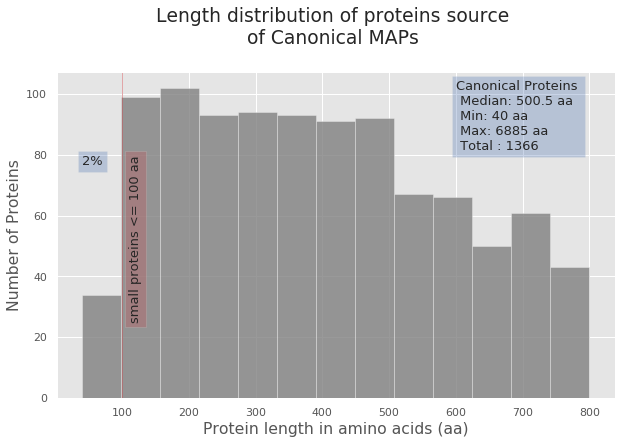

In [13]:
median_canonical, avg_canonical, min_canonical, max_canonical = get_stats_from_lenght(len_proteins_can, 'Canonical')

sum_lens = []
total_proteins = 0
small_proteins = 0

sum_lens = [x for x in len_proteins_can if x <= 800]
small_proteins += len([x for x in len_proteins_can if x <= 100])
total_proteins += len(len_proteins_can)

print
print 'Total Proteins ', total_proteins
print 'Total Small Proteins ', small_proteins
print 'Total Big Proteins ', total_proteins - small_proteins

pourcentage_sp = (small_proteins * 100)/total_proteins

title = 'Length distribution of proteins source \nof Canonical MAPs \n'
canonical_legend = 'Canonical Proteins \n Median: '+str(median_canonical)+' aa \n Min: '+str(min_canonical)+' aa \n Max: '+str(max_canonical)+' aa'
canonical_legend += '\n Total : '+str(total_proteins)
x_label = 'Protein length in amino acids (aa)'
y_label = 'Number of Proteins'
label = 'Canonical Proteins'

get_distribution_len_proteins(sum_lens, title, canonical_legend, pourcentage_sp, x_label, y_label, label)


# Get Biotypes for non canonical Proteins

Input Files
```python
"""
    only_non_canonical_proteins : dic
        Dic that contains for each peptide the information of the non canonical source protein
"""
```
Output Files

```python
"""
    toIntersectBackward_non_canonical.bed : bed-like file
        Bed file with the information for each peptide position and protein in the backward strand
        
    toIntersectForward_non_canonical.bed : bed-like file
        Bed file with the information for each peptide position and protein in the forward strand
"""
```

In [14]:

print 'Biotype Non Canonical proteins'
biotypes.restartDictionnary()
categories_non_canonical, proteins_non_canonical = biotypes.getBioTypeAlternTis(only_non_canonical_proteins, 'non_canonical')
    

Biotype Non Canonical proteins
Categories Proteins  {'Alt-TIS': 43, '3UTR': 3, '5UTR': 18, 'retained_intron': 7, 'antisense': 2, 'protein_coding': 1, 'Frameshift': 15, 'processed_transcript': 9, 'lincRNA': 1, 'processed_pseudogene': 5}
Total Peptides  153
Unique Proteins  141

Total small proteins  56  total peptides  57
Total big proteins  85  total peptides  96
Start codons origin  {'ATG': 70, 'AAG': 17, 'ACG': 7, 'ATC': 2, 'GTG': 9, 'AGG': 10, 'ATA': 4, 'ATT': 10, 'CTG': 23, 'TTG': 1}
high_number_prot :  3
key_high_number_prot :  STRG.107103.1_1-chr6:152302073-152302075--
peptides_high_number_prot :  ['AELAEIQEKW', 'SESADLIHW', 'KELENAVGSW']
Len Keys  141  Dif  0


# Intersection with Known annotations

To get additional information about the most likely biotype for each non canonical protein sorurce of maps

In [15]:
%%bash

#Non_Canonical
saveFile='../../Data_Output/'

module add bedtools
input=$saveFile'toIntersectBackward_non_canonical.bed'
input2='../../Data_Input_Scripts/gencode.v26.primary_assembly.annotation-.gtf'
output=$saveFile'toIntersectBackward_non_canonical_intersection.bed'
bedtools intersect -a $input -b $input2  -wao -f 1 | grep -w transcript > $output

input=$saveFile'toIntersectForward_non_canonical.bed'
input2='../../Data_Input_Scripts/gencode.v26.primary_assembly.annotation+.gtf'
output=$saveFile'toIntersectForward_non_canonical_intersection.bed'
bedtools intersect -a $input -b $input2  -wao -f 1 | grep -w transcript > $output

***** WARNING: File ../../Data_Input_Scripts/gencode.v26.primary_assembly.annotation-.gtf has inconsistent naming convention for record:
GL000009.2	ENSEMBL	gene	56140	58376	.	-	.	gene_id "ENSG00000278704.1"; gene_type "protein_coding"; gene_name "BX004987.1"; level 3;

***** WARNING: File ../../Data_Input_Scripts/gencode.v26.primary_assembly.annotation-.gtf has inconsistent naming convention for record:
GL000009.2	ENSEMBL	gene	56140	58376	.	-	.	gene_id "ENSG00000278704.1"; gene_type "protein_coding"; gene_name "BX004987.1"; level 3;

***** WARNING: File ../../Data_Input_Scripts/gencode.v26.primary_assembly.annotation+.gtf has inconsistent naming convention for record:
GL000195.1	ENSEMBL	gene	173872	179372	.	+	.	gene_id "ENSG00000278198.1"; gene_type "protein_coding"; gene_name "AC011043.2"; level 3;

***** WARNING: File ../../Data_Input_Scripts/gencode.v26.primary_assembly.annotation+.gtf has inconsistent naming convention for record:
GL000195.1	ENSEMBL	gene	173872	179372	.	+	.	gene_id

# Get resume Non Canonical Proteins

In [17]:
print 'Get Origin Peptides Non Canonical'
saveFile = '../../Data_Output/'   

start_codons_bed_file_backward = '../../Data_Output/toIntersectBackward_non_canonical.bed'
start_codons_bed_file_intersected_backward = '../../Data_Output/toIntersectBackward_non_canonical_intersection.bed'
annotations_file = '../../Data_Input_Scripts/Info_Transcripts_Annotations.dic'

start_codons_bed_file_forward = '../../Data_Output/toIntersectForward_non_canonical.bed'
start_codons_bed_file_intersected_forward = '../../Data_Output/toIntersectForward_non_canonical_intersection.bed'


freeByesSNPs='.../FreeBayes/output.var.5X.pga'
quality=20

name = 'DOHH2_Cryptic'
'../../Scripts/4_Get_Active_Transcripts/Canonical_Proteins/'
genome='../../Data_Input_Scripts/GRCh38_Gencode26/GRCh38.primary_assembly.genome.fa'
genomeFai='../../Data_Input_Scripts/GRCh38_Gencode26/GRCh38.primary_assembly.genome.fa.fai'

res_get_origin_non_can = getOrigin.main(['-s', saveFile, '-b', start_codons_bed_file_backward, '-i', start_codons_bed_file_intersected_backward, '-a',annotations_file, '-f', start_codons_bed_file_forward, '-d', start_codons_bed_file_intersected_forward, '-n', name, '-g', genome, '-x', genomeFai,  '-l', freeByesSNPs, '-q', quality])

to_calcule_pie_non_can = res_get_origin_non_can[0]
origin_by_peptide_non_can = res_get_origin_non_can[1]
origin_of_each_peptide_non_can = res_get_origin_non_can[2]
len_proteins_non_can = res_get_origin_non_can[3]
len_proteins_by_type_non_can = res_get_origin_non_can[4]
tpm_proteins_non_can = res_get_origin_non_can[5]

Get Origin Peptides Non Canonical
Total peptides in  -  strand = 74
Total peptides in  +  strand = 79
Total Peptides  153

Biotype Protein source peptides  =  {'3UTR': 4, 'Exons': 22, '5UTR': 23, 'Intergenic': 10, 'Frameshift': 16, 'Introns': 1, 'Alt-TIS': 77}
sizes =  [142, 10, 1]
Total SNPs Over the qualityThreshold  20  :  305952
Total runtime getSNPsDic : 0.00661225318909 min
getTranscriptInformation OK
Total Proteins  141
Total set Proteins  141

===========Info Proteins ===========
DOHH2_Cryptic_Total_small_proteins = 56
DOHH2_Cryptic_Total_big_proteins = 85
DOHH2_Cryptic_Total_peptides_small_proteins = 57
DOHH2_Cryptic_Total_peptides_big_proteins = 96

Total Proteins with one or more support peptides  10
Min Number of peptides  2  Max number of peptides  3

origin_by_protein =  {'3UTR': 3, 'Exons': 21, '5UTR': 23, 'Intergenic': 10, 'Frameshift': 16, 'Introns': 1, 'Alt-TIS': 67}
sizes =  [130, 10, 1]

Total time running function  1.42373563449  min
Total origin_of_each_peptide  1

## Length distribution Non-canonical proteins


Total Proteins  141
Total Small Proteins  56
Total Big Proteins  85
Total  Non-Canonical  Proteins  141
Median  Non-Canonical  Proteins  230.0
Mode  Non-Canonical  Proteins  11
Avg  Non-Canonical  Proteins  485.41843971631204
Minimum Length  Non-Canonical  Proteins  11
Maximum Length  Non-Canonical  Proteins  3914



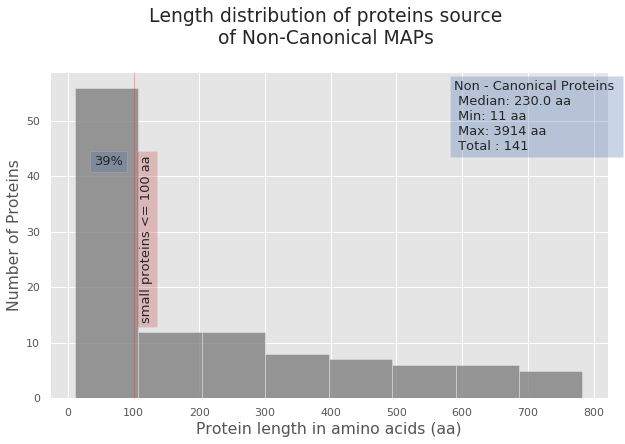

In [18]:
len_proteins_non_can = []
sum_lens = []
total_proteins = 0
small_proteins = 0

for cat, value in len_proteins_by_type_non_can.items():
    j2 = [x for x in value if x <= 800]
    small_proteins += len([x for x in value if x <= 100])
    sum_lens.extend(j2)
    total_proteins += len(value)
    len_proteins_non_can.extend(value)

print
print 'Total Proteins ', total_proteins
print 'Total Small Proteins ', small_proteins
print 'Total Big Proteins ', total_proteins - small_proteins

pourcentage_sp = (small_proteins * 100)/total_proteins

median_non_canonical, avg_non_canonical, min_non_canonical, max_non_canonical = get_stats_from_lenght(len_proteins_non_can, 'Non-Canonical')


title = 'Length distribution of proteins source \nof Non-Canonical MAPs \n'
non_canonical_legend = 'Non - Canonical Proteins \n Median: '+str(median_non_canonical)+' aa \n Min: '+str(min_non_canonical)+' aa \n Max: '+str(max_non_canonical)+' aa'
non_canonical_legend += '\n Total : '+str(total_proteins)
x_label = 'Protein length in amino acids (aa)'
y_label = 'Number of Proteins'
label = 'Non-Canonical Proteins'

get_distribution_len_proteins(sum_lens, title, non_canonical_legend, pourcentage_sp, x_label, y_label, label)

## Biotype Cryptic Proteins

In [19]:
def plot_pie(title, labels, labels_gender, sizes, sizes_gender, explode2, explode1, fontsize=18):
    fig, ax = plt.subplots(figsize=(11, 7), dpi=300) 
    title=title+'\n'
    colors_gender = ['lightcoral', 'lightskyblue', '#66b32f', '#c2c2f0', 'yellowgreen', 'mediumpurple', 'darkorchid']
    colors = ['lightpink', 'yellowgreen', 'mediumpurple', 'darkorchid']

    # Plot
    wedges1, texts1 = plt.pie(sizes, explode=explode1, colors=colors, startangle=180, pctdistance=0.9, shadow=False, textprops={'fontsize': fontsize, 'fontweight' : 'bold'})
    wedges, texts, autotexts = plt.pie(sizes_gender, explode=explode2, colors=colors_gender, radius=0.8,startangle=180, textprops={'fontsize': fontsize, 'fontweight' : 'bold'}, shadow=True, autopct='%1.0f%%', pctdistance=0.8)
    plt.legend(wedges1, labels, loc="best", bbox_to_anchor=(0.7,-0.05, 0.5, 0.5), fontsize = fontsize, frameon=True)

    bbox_props = dict(boxstyle="square,pad=0.2", color='black', fc="w", ec="k", lw=0.2)
    kw = dict(arrowprops=dict(arrowstyle="-", color='black', linewidth=2),zorder=2, va="center")
    plt.axis('equal')
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels_gender[i], xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y), horizontalalignment=horizontalalignment, fontsize = fontsize,fontweight = 'bold', **kw)

    plt.show()


In [20]:
positions = {'3UTR': 0,'5UTR': 1, 'Frameshift' : 2, 'Alt-TIS': 3,  'Exons': 4, 'Intergenic': 5, 'Introns': 6 }
sizes = 4*[0]
sizes_gender = 7*[0]

sum_exons = 0
for type_, value in to_calcule_pie_non_can.items():
    if type_ != 'Intergenic' and type_ != 'Introns' and type_ != 'Exons':
        sum_exons += value
        pos = positions[type_]
        sizes_gender[pos] = value
    elif type_ == 'Exons':
        sizes[1] += value
        pos = positions[type_]
        sizes_gender[pos] = value
    elif type_ == 'Intergenic':
        sizes[2] += value
        pos = positions[type_]
        sizes_gender[pos] = value
    else:
        sizes[3] += value
        pos = positions[type_]
        sizes_gender[pos] = value
sizes[0] = sum_exons

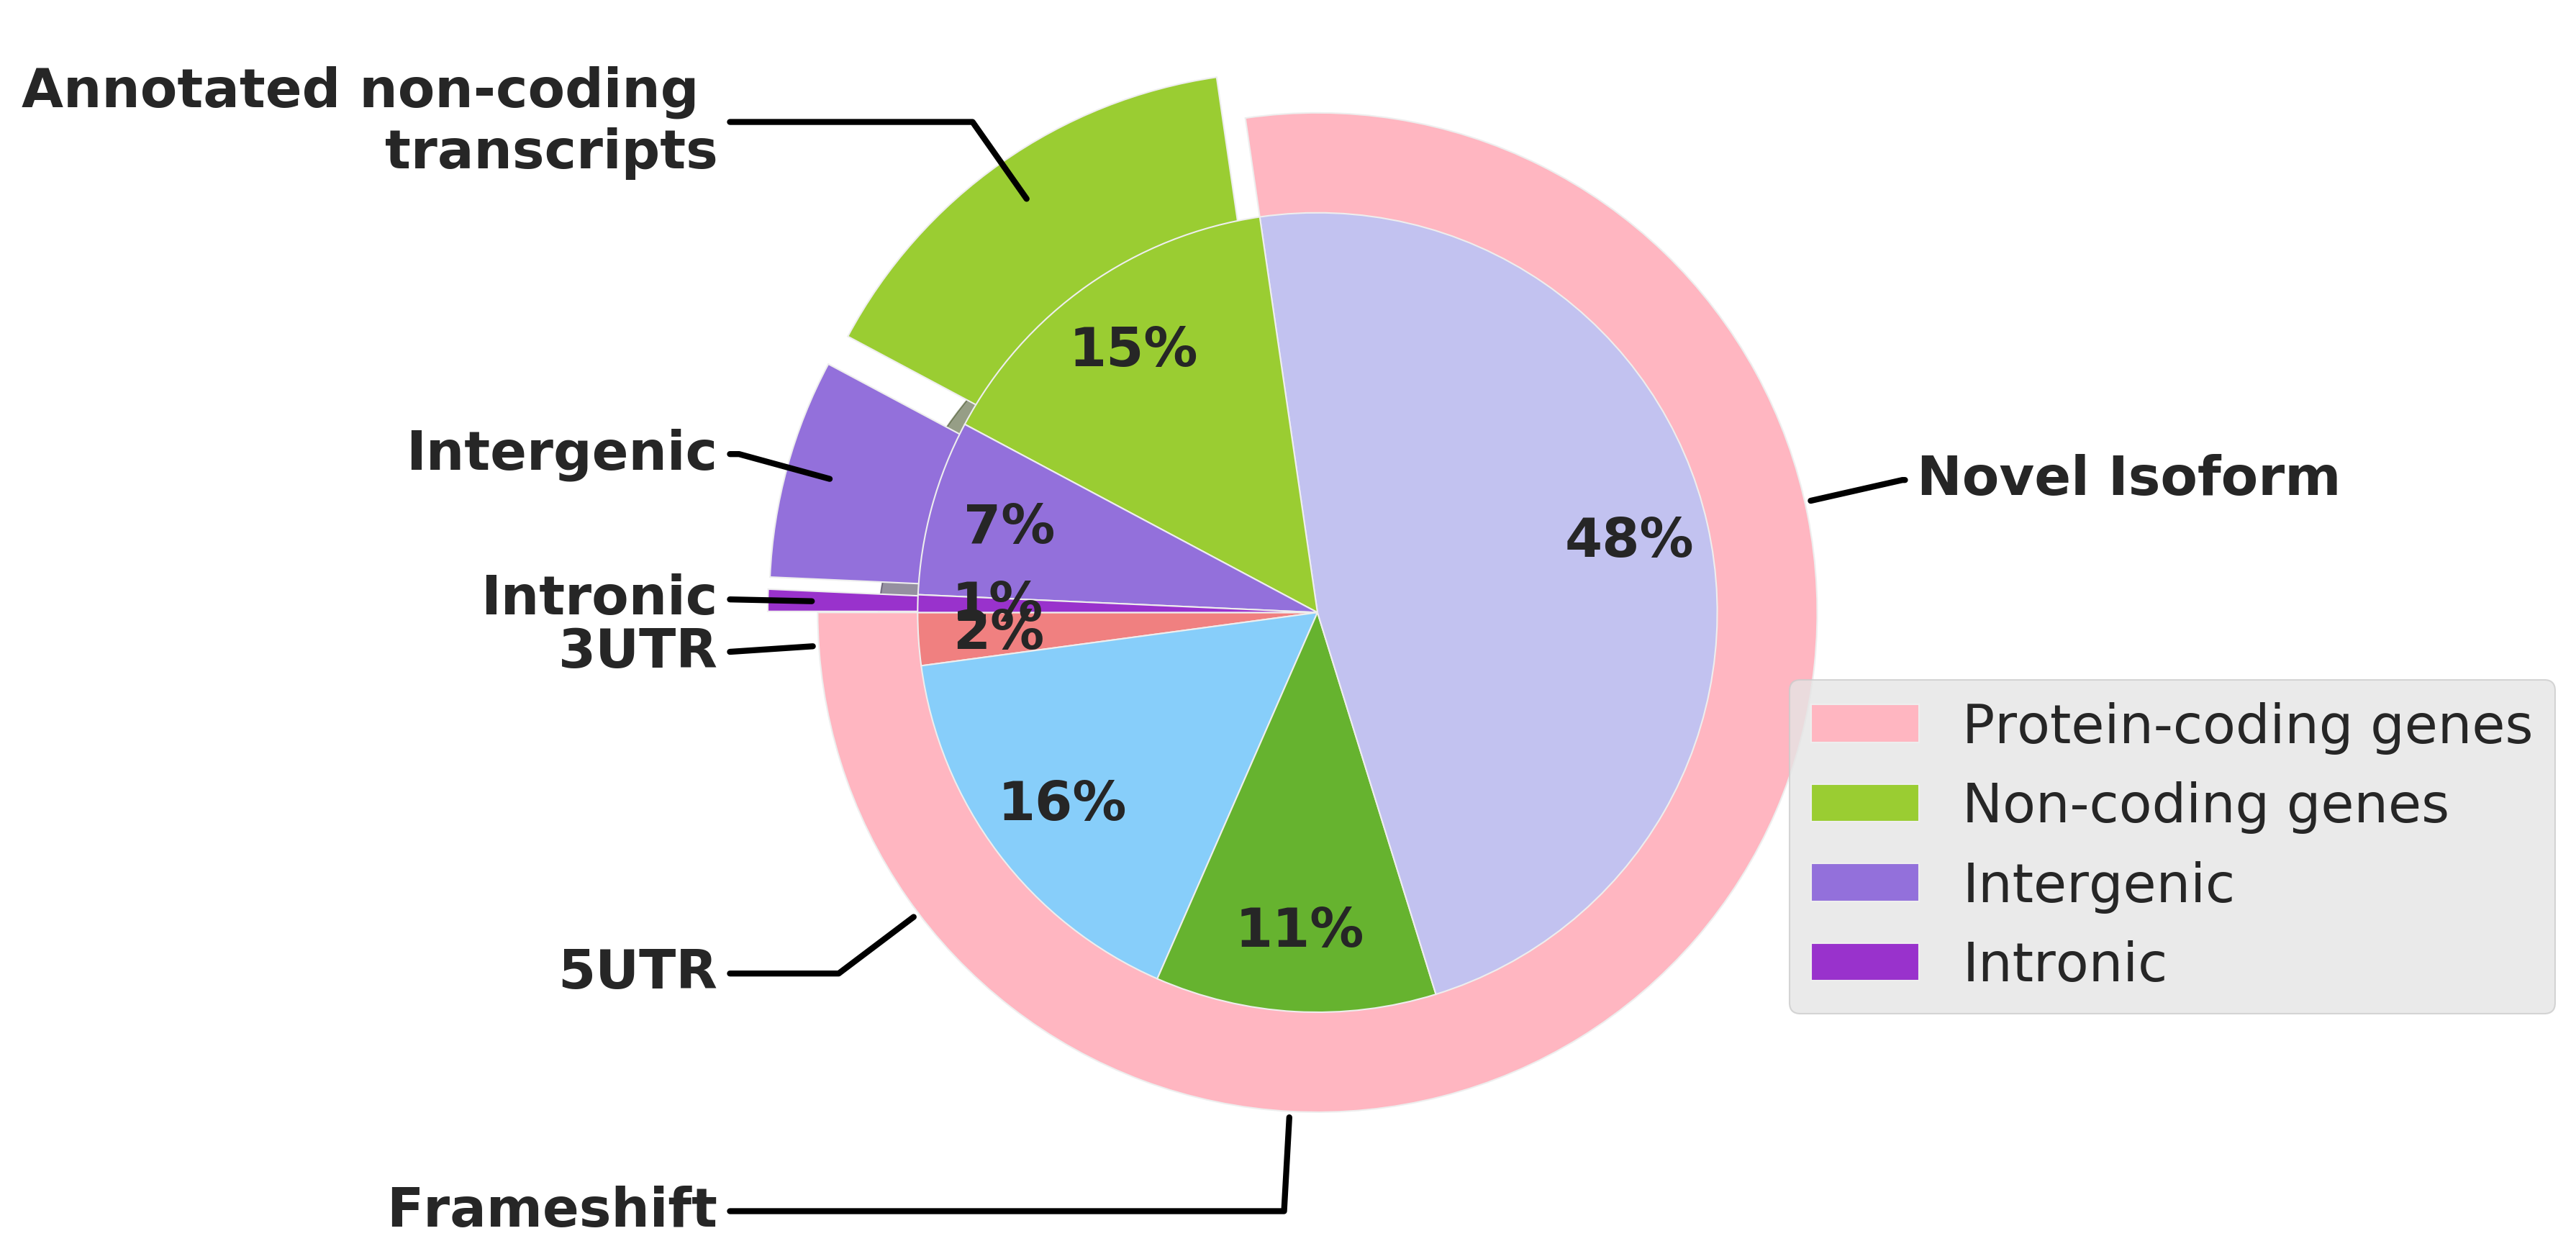

In [21]:
labels = ['Exonic', 'Intergenic', 'Intronic']
keys = ['3UTR', '5UTR', 'Frameshift', 'Alt-TIS', 'Exons', 'Intergenic', 'Introns']
explode2 = (0,0,0,0,0,0,0)
explode1 = (0,0.1,0.1,0.1)

title = 'Biotypes of non canonical Proteins DOHH2'
labels = ['Protein-coding genes', 'Non-coding genes', 'Intergenic', 'Intronic']
keys = ['3UTR', '5UTR', 'Frameshift', 'Novel Isoform', 'Annotated non-coding \ntranscripts', 'Intergenic', 'Intronic']

plot_pie(title, labels, keys, sizes, sizes_gender, explode2, explode1)
